In [1]:
# Create Spark Session

from pyspark.sql import SparkSession

spark = SparkSession \
        .builder \
        .appName("Read Voter File Data") \
        .getOrCreate()

24/03/21 01:36:51 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
# global variables 
class_bucket_name = "winter-2024-voter-file"
local_bucket_name = "pstat135-final-project1"
class_folder_name = "VM2Uniform"  

In [3]:
""" Use these functions to [read/write] [parquet files/data frames] [from/to] Google Cloud"""

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, count

def read_parquet_file(spark_session, file_path):
    """
    Reads a Parquet file and returns a Spark DataFrame.
    
    Parameters:
    spark_session (SparkSession): An active SparkSession.
    file_path (str): The path to the Parquet file.

    Returns:
    DataFrame: A Spark DataFrame containing the data from the Parquet file.
    """

    # Read the Parquet file
    df = (
        spark_session.read
        .format("parquet")
        .option("header", "true")
        .option("inferSchema", "true")
        .load(file_path)
    )

    return df


def write_df_to_gcs_parquet(spark_session, df, bucket_name, file_path):
    """
    Writes a Spark DataFrame to a Google Cloud Storage bucket as a Parquet file.
    
    Parameters:
    spark_session (SparkSession): An active SparkSession.
    df (DataFrame): The Spark DataFrame to write.
    bucket_name (str): The name of the Google Cloud Storage bucket.
    file_path (str): The file path within the bucket where the Parquet file will be saved.
    """
    
    # Define the GCS path
    gcs_path = f"gs://{bucket_name}/data_cleaned/{file_path}"

    # Write the DataFrame as a Parquet file to GCS
    df.write.parquet(gcs_path, mode='overwrite')
    

def list_content(bucket_name):
    """
    Lists all the blobs in the bucket.
    
    Parameters: 
    bucket_name (str): The name of the Google Cloud Storage bucket. 
    """
    storage_client = storage.Client()
    content = storage_client.list_blobs(bucket_name)
    
    for file in content:
        print(file.name)

def column_missing_percentage1(df):
    """
    Calculate the percentage of missing values for each column in the DataFrame.
    
    Parameters:
    df (DataFrame): A Spark DataFrame.
    
    Returns:
    DataFrame: A new DataFrame with two columns: 'Column_Name' and 'Missing_Percentage'.
    """
    missing_percentage_data = []
    total_count = df.count()
    
    for c in df.columns:
        missing_count = df.filter(col(c).isNull() | (col(c) == '')).count()
        missing_percentage = (missing_count / total_count) * 100
        missing_percentage_data.append((c, missing_percentage))
    
    missing_percentage_df = spark.createDataFrame(missing_percentage_data, ["Column_Name", "Missing_Percentage"])
    return missing_percentage_df

In [4]:
df_final = read_parquet_file(spark, "gs://pstat135-final-project1/data_cleaned/dataset_young_demographic")

In [5]:
from pyspark.sql.functions import when, col, regexp_replace
from pyspark.ml.feature import StringIndexer


def clean_dataset(df):
    """
    Clean our dataset by applying the following: 
        1) Convert 'CommercialData_EstHomeValue' from string to int data type
        2) Extract state from `LALVOTERID`
        3) Convert `Voters_Gender` into a 0/1 depending on Gender
        4) Fill missing values in 'General_2020', 'PresidentialPrimary_2020', 'Primary_2020'
    
    Parameters:
    df (DataFrame): A Spark DataFrame.
    
    Returns:
    DataFrame: A new DataFrame with the necessary columns. 
    """
    df_num = df.withColumn("CommercialData_EstHomeValue_in_Dollars", regexp_replace("CommercialData_EstHomeValue", "\\$", "").cast("int"))    
    df_with_state = df_num.withColumn("State", col("LALVOTERID").substr(4, 2))
    cleaned_df = df_with_state.filter(df_with_state.Voters_Gender.isNotNull())
    converted_df = cleaned_df.withColumn("Gender", when(col("Voters_Gender") == "M", 1).otherwise(0))
    converted_df = converted_df.filter(converted_df.CommercialData_EstimatedHHIncome.isNotNull())
    
    indexer = StringIndexer(inputCol="CommercialData_EstimatedHHIncome", outputCol="CommercialData_EstimatedHHIncome_ctg", handleInvalid="skip")

    # Fit and transform the DataFrame
    model = indexer.fit(converted_df)
    df_categorical = model.transform(converted_df)
    
    df_a = df_categorical.fillna({'General_2020': 'N'})
    df_b = df_a.fillna({'PresidentialPrimary_2020': 'N'})
    df_c = df_b.fillna({'Primary_2020': 'N'})
    
    df_final = df_c.drop("Voters_StateVoterID")
    return df_final

In [6]:
df_final = clean_dataset(df_final)
df_final.printSchema()

root
 |-- Voters_FirstName: string (nullable = true)
 |-- Voters_LastName: string (nullable = true)
 |-- LALVOTERID: string (nullable = true)
 |-- Voters_Age: string (nullable = true)
 |-- Voters_Gender: string (nullable = true)
 |-- General_2020: string (nullable = false)
 |-- Primary_2020: string (nullable = false)
 |-- Ethnic_Description: string (nullable = true)
 |-- PresidentialPrimary_2020: string (nullable = false)
 |-- EthnicGroups_EthnicGroup1Desc: string (nullable = true)
 |-- CommercialData_Education: string (nullable = true)
 |-- CommercialData_EstHomeValue: string (nullable = true)
 |-- CommercialData_EstimatedHHIncome: string (nullable = true)
 |-- CommercialData_EstHomeValue_in_Dollars: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- Gender: integer (nullable = false)
 |-- CommercialData_EstimatedHHIncome_ctg: double (nullable = false)



In [7]:
# Random Forest 
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

df_model = df_final.select('Voters_Age','Voters_Gender', 'General_2020', 'EthnicGroups_EthnicGroup1Desc', 
                           'CommercialData_EstHomeValue_in_Dollars', 'CommercialData_EstimatedHHIncome', 
                            'State')

df_model_cleaned = df_model.dropna()
df_model_cleaned = df_model_cleaned.withColumn("Voters_Age_int", col("Voters_Age").cast("int"))
df_model_cleaned = df_model_cleaned.drop("Voters_Age")

df = df_model_cleaned.sample(False, 0.2)

df.printSchema()

root
 |-- Voters_Gender: string (nullable = true)
 |-- General_2020: string (nullable = false)
 |-- EthnicGroups_EthnicGroup1Desc: string (nullable = true)
 |-- CommercialData_EstHomeValue_in_Dollars: integer (nullable = true)
 |-- CommercialData_EstimatedHHIncome: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Voters_Age_int: integer (nullable = true)



In [9]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import when
from pyspark.ml.regression import RandomForestRegressor

# Convert General_2020 to binary
df = df.withColumn("label", when(df.General_2020 == "Y", 1).otherwise(0))

# StringIndexer for categorical variables 
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in ['Voters_Gender', 'State', 
                                                                                             'EthnicGroups_EthnicGroup1Desc', 
                                                                                             'CommercialData_EstimatedHHIncome']]
# OneHotEncoding for categorical variables
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getOutputCol()+"_vec") for indexer in indexers]

# Assemble all feature columns (including numerical features) into a single vector
assemblerInputs = [encoder.getOutputCol() for encoder in encoders] + ['CommercialData_EstHomeValue_in_Dollars', 'Voters_Age_int']
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

# Initialize the RandomForestRegressor
rf_regressor = RandomForestRegressor(labelCol="label", featuresCol="features", numTrees=100, seed=42)

# Construct the pipeline with all the stages
pipeline = Pipeline(stages=indexers + encoders + [assembler, rf_regressor])

# Split the DataFrame into training and test sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Fit the model on the training data
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Display predictions
predictions.select("prediction", "label", "features").show()

+-------------------+-----+--------------------+
|         prediction|label|            features|
+-------------------+-----+--------------------+
| 0.4958601151843192|    0|(61,[0,9,47,58,59...|
|0.49424549542082474|    0|(61,[0,8,47,50,59...|
| 0.4853874275257432|    0|(61,[0,12,47,50,5...|
| 0.4873011518556642|    0|(61,[0,12,47,50,5...|
|  0.497769410863256|    0|(61,[0,12,47,53,5...|
|0.49559743601102213|    0|(61,[0,8,47,50,59...|
| 0.5124375880869314|    0|(61,[0,4,47,48,59...|
| 0.5208401249221397|    0|(61,[0,6,47,48,59...|
| 0.5544897469993332|    0|(61,[0,12,47,49,5...|
| 0.5504729454366774|    0|(61,[0,8,47,53,59...|
| 0.5427514863119554|    0|(61,[0,11,47,48,5...|
| 0.5494357661202861|    0|(61,[0,8,47,53,59...|
| 0.5452746047785235|    0|(61,[0,12,47,48,5...|
| 0.5587796078551024|    0|(61,[0,11,47,49,5...|
| 0.5371380478426214|    0|(61,[0,4,47,48,59...|
| 0.5462724942553696|    0|(61,[0,14,47,48,5...|
| 0.5545653648999794|    0|(61,[0,12,47,49,5...|
| 0.6145561261083344

In [10]:
# Evaluate model regression
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")

RMSE: 0.47362478624798293


In [11]:
# Extract Feature importances
# Assuming 'model' is the fitted pipeline model
rf_model = model.stages[-1]  # The last stage in the pipeline is the RandomForestRegressor

# Feature importance scores
importances = rf_model.featureImportances


In [12]:
# Match Feature Importance Scores with Feature Names
# Feature names as inputted to VectorAssembler, adjust as per your actual features
feature_names = assemblerInputs  # assemblerInputs was used in VectorAssembler

# Convert feature importances to a list if not already
importance_scores = importances.toArray()

# Match feature names with their importance scores
feature_importance_list = [(name, score) for name, score in zip(feature_names, importance_scores)]


[('Voters_Gender_index_vec', 0.06212627494812043), ('State_index_vec', 0.019574721054262834), ('EthnicGroups_EthnicGroup1Desc_index_vec', 0.00024113898445531586), ('CommercialData_EstimatedHHIncome_index_vec', 0.0032139447038874915), ('CommercialData_EstHomeValue_in_Dollars', 0.004042188709923108), ('Voters_Age_int', 0.01972797333250717)]
('Voters_Gender_index_vec', 'Voters_Age_int', 'State_index_vec', 'CommercialData_EstHomeValue_in_Dollars', 'CommercialData_EstimatedHHIncome_index_vec', 'EthnicGroups_EthnicGroup1Desc_index_vec')


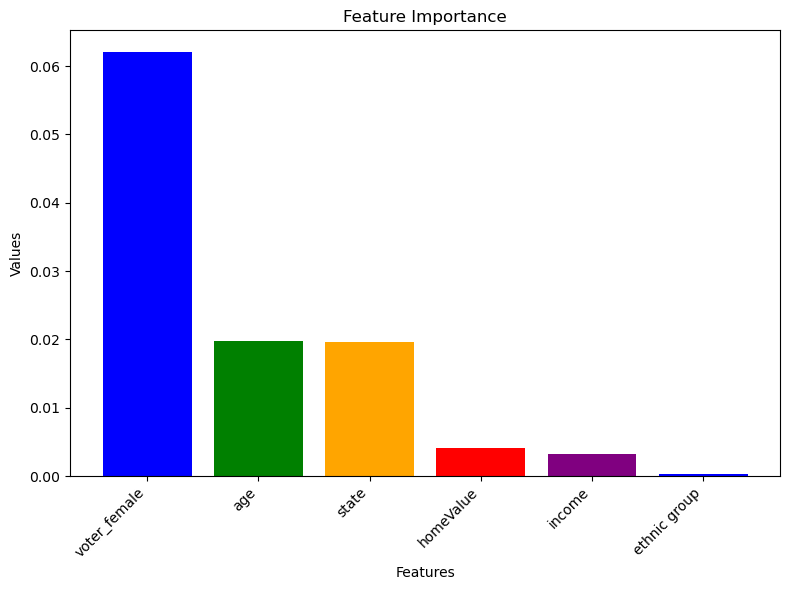

In [37]:
import matplotlib.pyplot as plt

print(feature_importance_list)

feature_importance_list_sorted  = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

name, value = zip(*feature_importance_list_sorted)
print(name)

name = ['voter_female', 'age', 'state', 'homeValue', 'income', 'ethnic group']

plt.figure(figsize=(8, 6))
plt.bar(name, value, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.xlabel("Features")
plt.ylabel("Values")
plt.title("Feature Importance")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()




In [13]:
from pyspark.ml.evaluation import RegressionEvaluator

# Create a RegressionEvaluator object for RMSE
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# Apply the evaluator to the predictions DataFrame
rmse = evaluator_rmse.evaluate(predictions)

# Repeat for other metrics, like MAE and MSE
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)

evaluator_mse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
mse = evaluator_mse.evaluate(predictions)

print(rmse)
print(mae)
print(mse)

0.47362478624798293
0.4539386742313705
0.22432043814844754


In [14]:
# Test Significance

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Assuming `df` is DataFrame, `X` are  features, and `y` is target variable.
X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], test_size=0.2, random_state=42)

# Fit the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for easier visualization
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

print(features_df)


NameError: name 'X' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Sort features by importance
feature_importance_list.sort(key=lambda x: x[1], reverse=True)

# Unzip into names and scores
names, scores = zip(*feature_importance_list)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(names)), scores, align='center')
plt.yticks(range(len(names)), names)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance Chart')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()
